<h1><center>Optimal Portfolio Allocation through CDaR</center></h1>
<h2><center>LSM Investment Club - Team Quant</center></h2>
<h3><center>Adrien</center></h3>

In [15]:
minimal_w = 0.02
maximal_w = 0.10

The club has required us to make the selection with minimal and maximal weights, as the stocks were chosen by the portfolio team through equity research. We only need to choose the weight to apply to each stock, but this is less optimal for our method, considering that the base result could set many stocks to 0.

In [16]:
import yfinance as yf
import numpy as np
tickers = {
    "2B78.DE": 68,
    "AAPL": 15,
    "AED.BR": 13,
    "BFIT.AS": 17,
    "BX": 5,
    "EVO.ST": 4,
    "ENPH": 5,
    "IGLN.L": 43,
    "IESE.AS": 17,
    "IQQH.DE": 58,
    "MC.PA": 3,
    "MRK": 13,
    "MSFT": 8,
    "NESN.SW": 5,
    "OGN": 1,
    "RCF.F": 5,
    "STMPA.PA": 15,
    "TCEHY": 17,
    "UMI.BR": 14,
    "WLN.PA": 11
}

start_train_date = "2023-06-01"
end_train_date = "2024-03-01"
start_test_date = end_train_date
end_test_date = "2024-11-25"



df = yf.download(list(tickers.keys()), start=start_train_date, end=end_train_date)['Close'].dropna()
df.index = df.index.strftime('%Y-%m-%d') # Omit the time on the date
df_test =  yf.download(list(tickers.keys()), start=start_test_date, end=end_test_date)['Close'].dropna()
df_test.index = df_test.index.strftime('%Y-%m-%d') 


[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed


### Convert the value of all stocks into euros

In [17]:
import pandas as pd

tickers_curr = {
    "2B78.DE": "EUR", "AAPL": "USD", "AED.BR": "EUR", "BFIT.AS": "EUR",
    "BX": "USD", "EVO.ST": "SEK", "ENPH": "USD", "IGLN.L": "GBP",
    "IESE.AS": "EUR", "IQQH.DE": "EUR", "MC.PA": "EUR", "MRK": "USD",
    "MSFT": "USD", "NESN.SW": "CHF", "OGN": "USD", "RCF.F": "EUR",
    "STMPA.PA": "EUR", "TCEHY": "HKD", "UMI.BR": "EUR", "WLN.PA": "EUR"
}


df = yf.download(list(tickers_curr.keys()), start=start_train_date, end=end_train_date)['Close'].dropna()

currencies = set(tickers_curr.values())
fx_tickers = [f"{curr}EUR=X" for curr in currencies if curr != "EUR"] 
fx_rates = yf.download(fx_tickers, start=start_train_date, end=end_train_date)['Close']

fx_rates['EUR'] = 1.0  
fx_rates = fx_rates.ffill().bfill() 

fx_rates.columns = [col.replace('=X', '').replace('EUR', '') for col in fx_rates.columns]

for ticker, currency in tickers_curr.items():
    if currency != "EUR":
        conversion_rate = fx_rates[currency]
        df[ticker] = df[ticker] * conversion_rate

last_prices = df.iloc[-1]
print(last_prices)


[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  5 of 5 completed

Ticker
2B78.DE       7.037000
AAPL        166.761755
AED.BR       52.650002
BFIT.AS      24.900000
BX          117.928008
ENPH        117.180696
EVO.ST      119.697153
IESE.AS      67.559998
IGLN.L       46.459193
IQQH.DE       7.368000
MC.PA       842.799988
MRK         117.309861
MSFT        381.628408
NESN.SW      96.317720
OGN          16.062640
RCF.F       113.099998
STMPA.PA     41.724998
TCEHY         4.117609
UMI.BR       19.290001
WLN.PA       10.625000
Name: 2024-02-29 00:00:00+00:00, dtype: float64


In [18]:
value_by_ticker = [tickers[ticker_name]*last_prices.loc[ticker_name] for ticker_name in last_prices.index.tolist()]
portfolio_value = np.sum(value_by_ticker)
actual_weights = [val/portfolio_value for val in value_by_ticker]
print(portfolio_value)

18568.049711306936


## Method on the Mean Drawdown at Risk (Equivalent to Expected Shortfall for VaR)

Here, it's another metric, see https://en.wikipedia.org/wiki/Drawdown_(economics)
Also see the article, modeling on page 24 https://www.math.columbia.edu/~chekhlov/IJTheoreticalAppliedFinance.8.1.2005.pdf
And see also https://www.cis.upenn.edu/~mkearns/finread/drawdown.pdf

Compared to VaR, we look at each time $t$, the highest peak to the left, and subtract the current value of the price. The idea of keeping the drawdown under a certain threshold is to protect ourselves both financially from heavy losses and psychologically. If we observe a huge peak, we might be tempted to withdraw our investment to avoid even heavier losses. The main idea is that you need a 100% increase to recover your capital from a 50% loss.

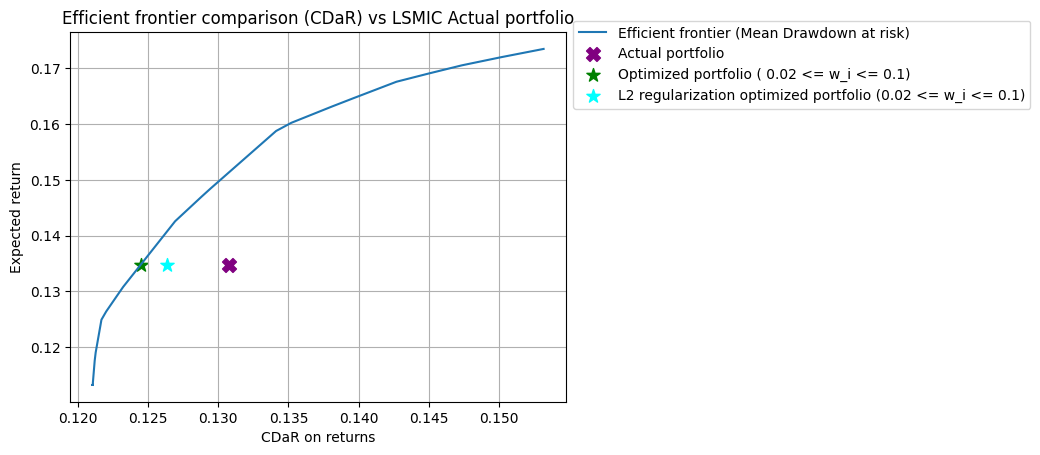

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import expected_returns,EfficientCDaR, objective_functions
from cvxpy import MOSEK

confidence_level = 0.99

mu = expected_returns.ema_historical_return(df)
actual_return = np.dot(actual_weights, mu)
historical_returns = expected_returns.returns_from_prices(df)

target_mu = np.linspace(0, max(mu), 500)
CDaR_Drawdown = []
returns_Drawdown = []

for ret in target_mu:
    try:
        es = EfficientCDaR(mu, historical_returns, weight_bounds=(0, 1), beta=confidence_level, solver=MOSEK)
        es.add_constraint(lambda x: x >= minimal_w)
        es.add_constraint(lambda x: x <= maximal_w)
        es.efficient_return(ret)
        portfolio_return, portfolio_CDaR = es.portfolio_performance()
        CDaR_Drawdown.append(portfolio_CDaR)
        returns_Drawdown.append(portfolio_return)
    except:
        break

plt.plot(CDaR_Drawdown, returns_Drawdown, label = "Efficient frontier (Mean Drawdown at risk)")

portfolio_returns = historical_returns.dot(actual_weights)
cumulative_returns = (1 + portfolio_returns).cumprod()
peak = cumulative_returns.cummax()
drawdowns = (cumulative_returns - peak) / peak
VaR_drawdown_actual = np.quantile(-drawdowns, confidence_level)
ActualCDaR = -drawdowns[drawdowns <= -VaR_drawdown_actual].mean()

plt.scatter(ActualCDaR, actual_return, marker="X", color="purple", s=100, label="Actual portfolio")
 
# Best Return for the Same CDaR
def get_weights_CDaR(option = "normal", min_weights = minimal_w, max_weights = maximal_w, gamma = 1, c = None, curr = None):
    es = EfficientCDaR(mu, historical_returns, weight_bounds=(0, 1), beta = confidence_level, solver = MOSEK)
    es.add_constraint(lambda x : x >= min_weights)
    es.add_constraint(lambda x : x <= max_weights)
    if(c != None):
        es.add_objective(objective_functions.transaction_cost, w_prev= curr, k=c)
    if option == "normal":
        weights_eff_cdar = es.efficient_return(actual_return)
        cleaned_weights_eff_cdar = es.clean_weights()
        optimized_return, optimized_CDaR= es.portfolio_performance()
        return cleaned_weights_eff_cdar, optimized_return, optimized_CDaR
    elif option == "L2 regularization":
        es.add_objective(objective_functions.L2_reg, gamma= gamma)
        weights_eff_cdar_L2 = es.efficient_return(actual_return)
        cleaned_weights_eff_cdar_L2 = es.clean_weights()
        optimized_return_L2, optimized_CDaR_L2 = es.portfolio_performance()
        return cleaned_weights_eff_cdar_L2,optimized_return_L2, optimized_CDaR_L2
    else:
        return
    
cleaned_weights_eff_cdar, optimized_return, optimized_CDaR = get_weights_CDaR("normal")
plt.scatter(optimized_CDaR, optimized_return, marker="*", color="green", s=100, label="Optimized portfolio ( 0.02 <= w_i <= 0.1)")
# Portfolio with a penalty on zero weights (L2 regularization)
cleaned_weights_eff_cdar_L2, optimized_return_L2, optimized_CDaR_L2 = get_weights_CDaR("L2 regularization")
plt.scatter(optimized_CDaR_L2, optimized_return_L2, marker="*", color="cyan", s=100, label="L2 regularization optimized portfolio (0.02 <= w_i <= 0.1)")

plt.title("Efficient frontier comparison (CDaR) vs LSMIC Actual portfolio")
plt.xlabel("CDaR on returns")
plt.ylabel("Expected return")
plt.legend(bbox_to_anchor = (1,1.05))
plt.grid()
plt.show()


## Allocation optimale pour max sharpe

In [20]:
from pypfopt import EfficientFrontier, DiscreteAllocation, expected_returns, CovarianceShrinkage

mu = expected_returns.ema_historical_return(df)
S = CovarianceShrinkage(df).ledoit_wolf(shrinkage_target = "constant_correlation") 
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
ef.add_constraint(lambda x: x >= minimal_w)
ef.add_constraint(lambda x: x <= maximal_w)

raw_weights_max_sharpe = ef.max_sharpe()
cleaned_weights_max_sharpe = ef.clean_weights() 
latest_prices = df.iloc[-1]  # latest prices at the end of the period

da = DiscreteAllocation(cleaned_weights_max_sharpe, latest_prices, total_portfolio_value=portfolio_value)
allocation_max_sharpe, leftover = da.lp_portfolio()

print("Discrete allocation in shares:", allocation_max_sharpe)
print("Remaining resources:", leftover)


Discrete allocation in shares: {'2B78.DE': 264, 'AAPL': 2, 'AED.BR': 7, 'BFIT.AS': 15, 'BX': 16, 'ENPH': 3, 'EVO.ST': 9, 'IESE.AS': 28, 'IGLN.L': 40, 'IQQH.DE': 49, 'MC.PA': 2, 'MRK': 16, 'MSFT': 5, 'NESN.SW': 4, 'OGN': 23, 'RCF.F': 4, 'STMPA.PA': 9, 'TCEHY': 91, 'UMI.BR': 19, 'WLN.PA': 35}
Remaining resources: 41.54012069494274


c:\Users\porti\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


## Optimal Allocation for Min Volatility

In [21]:
mu = expected_returns.ema_historical_return(df)
S = CovarianceShrinkage(df).ledoit_wolf(shrinkage_target = "constant_correlation") 
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
ef.add_constraint(lambda x: x >= minimal_w)
ef.add_constraint(lambda x: x <= maximal_w)

raw_weights_min_vol = ef.min_volatility()
cleaned_weights_min_vol = ef.clean_weights() 

latest_prices = df.iloc[-1]  # latest prices at the end of the period

da = DiscreteAllocation(cleaned_weights_min_vol, latest_prices, total_portfolio_value=portfolio_value)
allocation_min_vol, leftover = da.lp_portfolio()

print("Discrete allocation in shares:", allocation_min_vol)
print("Remaining resources:", leftover)


Discrete allocation in shares: {'2B78.DE': 264, 'AAPL': 11, 'AED.BR': 7, 'BFIT.AS': 15, 'BX': 3, 'ENPH': 4, 'EVO.ST': 5, 'IESE.AS': 28, 'IGLN.L': 40, 'IQQH.DE': 119, 'MRK': 16, 'MSFT': 5, 'NESN.SW': 20, 'OGN': 24, 'RCF.F': 4, 'STMPA.PA': 9, 'TCEHY': 100, 'UMI.BR': 19, 'WLN.PA': 36}
Remaining resources: 0.3666842156271741


c:\Users\porti\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


## Optimal Allocation for Min CVaR (Expected Shortfall)

In [22]:
from pypfopt import EfficientCVaR

mu = expected_returns.ema_historical_return(df)
S = CovarianceShrinkage(df).ledoit_wolf(shrinkage_target = "constant_correlation") 
ef = EfficientCVaR(mu, S, weight_bounds=(0, 1), beta = 0.99, solver = MOSEK)
ef.add_constraint(lambda x: x >= minimal_w)
ef.add_constraint(lambda x: x <= maximal_w)

raw_weights_min_cvar = ef.min_cvar()
cleaned_weights_min_cvar = ef.clean_weights() 

latest_prices = df.iloc[-1]  # latest prices at the end of the period

da = DiscreteAllocation(cleaned_weights_min_cvar, latest_prices, total_portfolio_value=portfolio_value)
allocation_min_vol, leftover = da.lp_portfolio()

print("Discrete allocation in shares:", allocation_min_vol)
print("Remaining resources:", leftover)

Discrete allocation in shares: {'2B78.DE': 55, 'AAPL': 2, 'AED.BR': 35, 'BFIT.AS': 16, 'BX': 4, 'ENPH': 16, 'EVO.ST': 3, 'IESE.AS': 5, 'IGLN.L': 40, 'IQQH.DE': 52, 'MC.PA': 1, 'MRK': 15, 'MSFT': 1, 'NESN.SW': 19, 'OGN': 117, 'RCF.F': 17, 'STMPA.PA': 9, 'TCEHY': 94, 'UMI.BR': 20, 'WLN.PA': 36}
Remaining resources: 174.32076543362928


c:\Users\porti\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


## Graphical comparison of returns relative to the portfolios

In [23]:
club_weights = {list(tickers.keys())[i]:actual_weights[i] for i in range(len(actual_weights))}

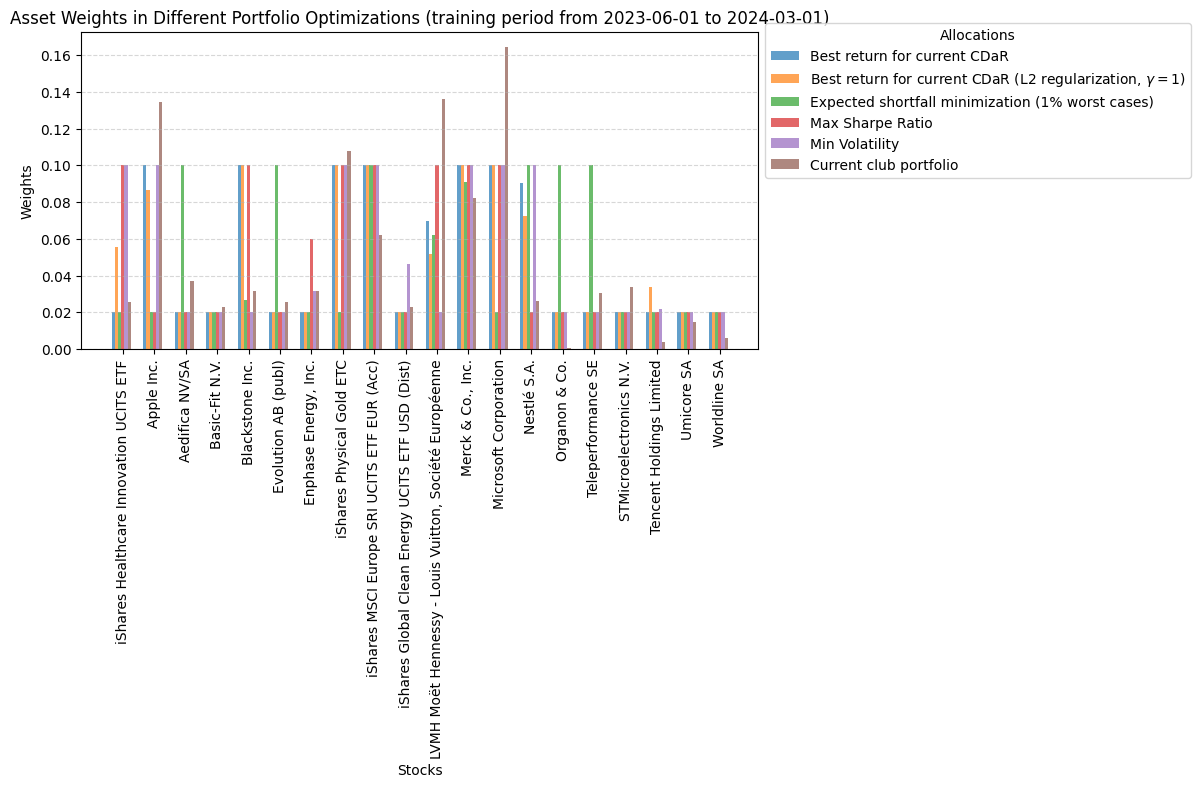

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

weights_dict = pd.DataFrame({
    "Best return for current CDaR" : pd.Series(cleaned_weights_eff_cdar),
    r"Best return for current CDaR (L2 regularization, $\gamma = 1$)" : pd.Series(cleaned_weights_eff_cdar_L2),
    "Expected shortfall minimization (1% worst cases)" : pd.Series(cleaned_weights_min_cvar), 
    'Max Sharpe Ratio': pd.Series(cleaned_weights_max_sharpe),
    'Min Volatility': pd.Series(cleaned_weights_min_vol),
    'Current club portfolio': pd.Series(club_weights)
})

ticker_names = [yf.Ticker(ticker).info['longName'] for ticker in tickers.keys()]


plt.figure(figsize=(12, 8))
bar_width = 0.15
spacing_factor = 1.5 
positions = np.arange(len(weights_dict.index)) * spacing_factor

for i, allocation in enumerate(weights_dict.columns):
    plt.bar(
        positions + i * bar_width,
        weights_dict[allocation], 
        width=bar_width,
        label=allocation,
        alpha=0.7
    )

plt.title('Asset Weights in Different Portfolio Optimizations' + 
          f" (training period from {start_train_date} to {end_train_date})")
plt.xlabel('Stocks')
plt.ylabel('Weights')
plt.xticks(ticks=positions + bar_width * (len(weights_dict.columns) / 2), labels=ticker_names, rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Allocations', bbox_to_anchor = (1,1.05))
plt.tight_layout()
plt.show()


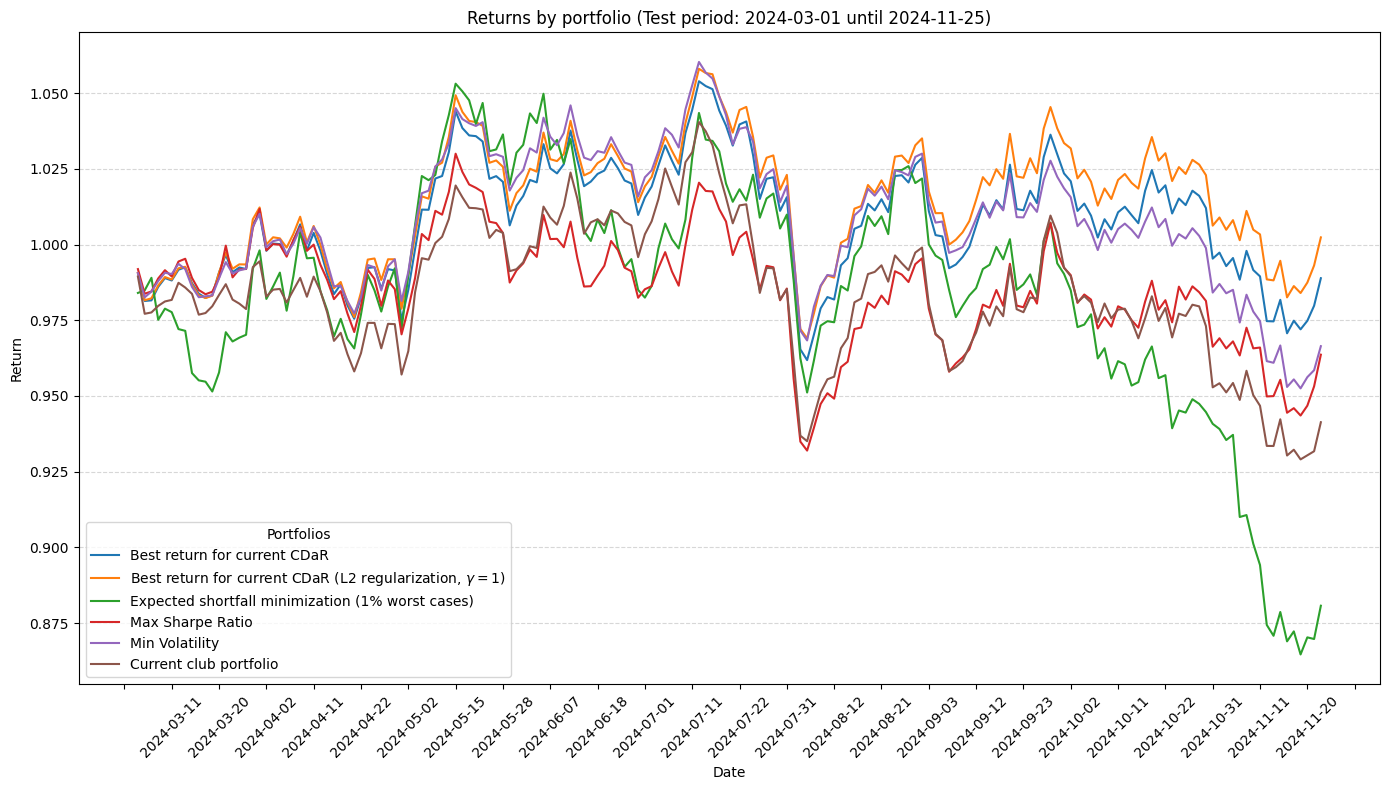

In [25]:
import matplotlib.dates as mdates

# Daily returns on test period
returns_test = expected_returns.returns_from_prices(df_test)

portfolio_cum_returns = {}
for name, weights in weights_dict.items():
    weights = weights.loc[df_test.columns].fillna(0)  # Ensure that columns align
    weighted_returns = returns_test @ weights  # Matrix product to apply weights
    portfolio_cum_returns[name] = (1 + weighted_returns).cumprod()  # Cumulative returns

portfolio_cum_returns_df = pd.DataFrame(portfolio_cum_returns)

plt.figure(figsize=(14, 8))
for portfolio, returns in portfolio_cum_returns_df.items():
    plt.plot(portfolio_cum_returns_df.index, returns, label=portfolio)

plt.title("Returns by portfolio (Test period: " + start_test_date + " until " + end_test_date + ")")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend(title="Portfolios")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.tight_layout()
plt.show()


## Performance of Different Methods with Allocation Compared to the Club's Current Portfolio Performance Without Changes. Cost Fixed at 1%

In [26]:
unif_weights = club_weights.copy()
for ticker in club_weights.keys():
    unif_weights[ticker] = 1/len(club_weights)

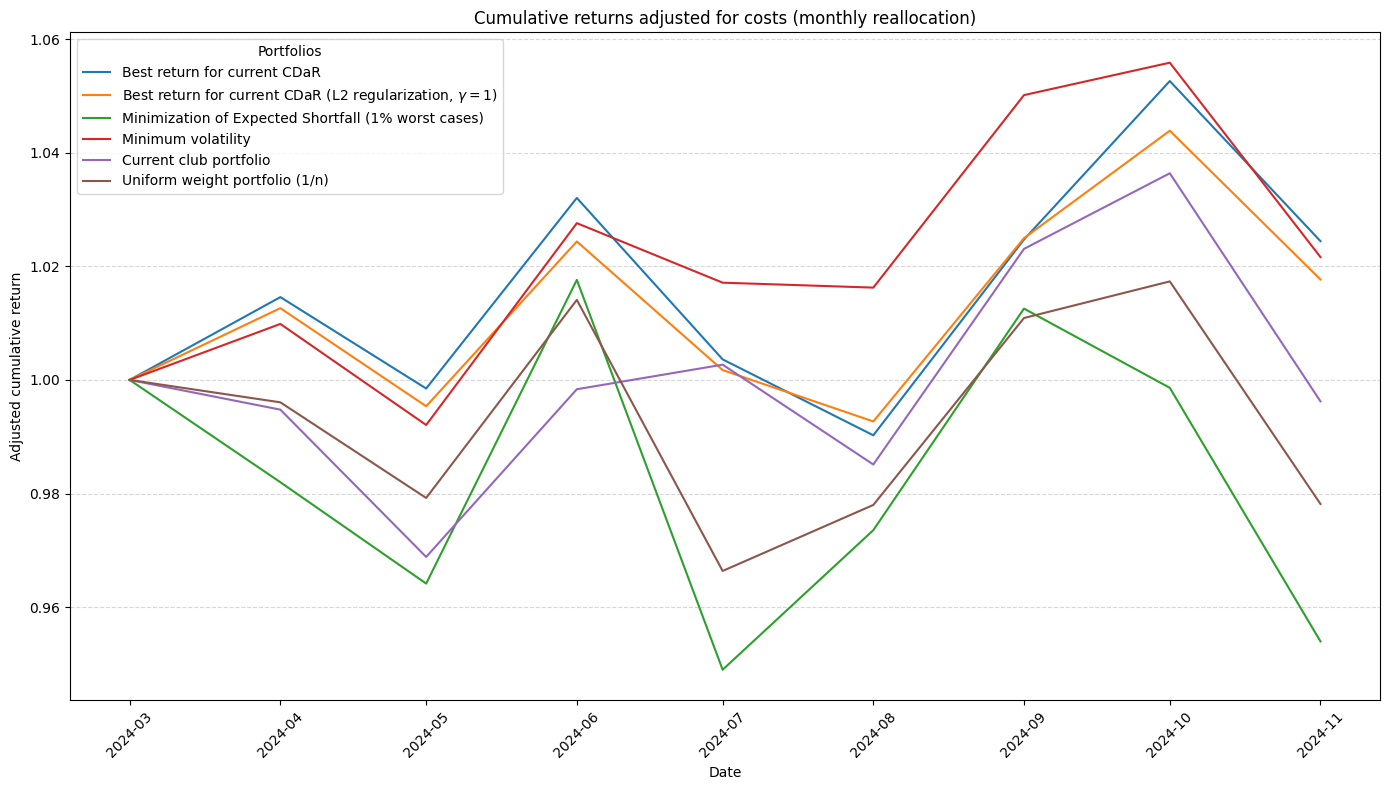

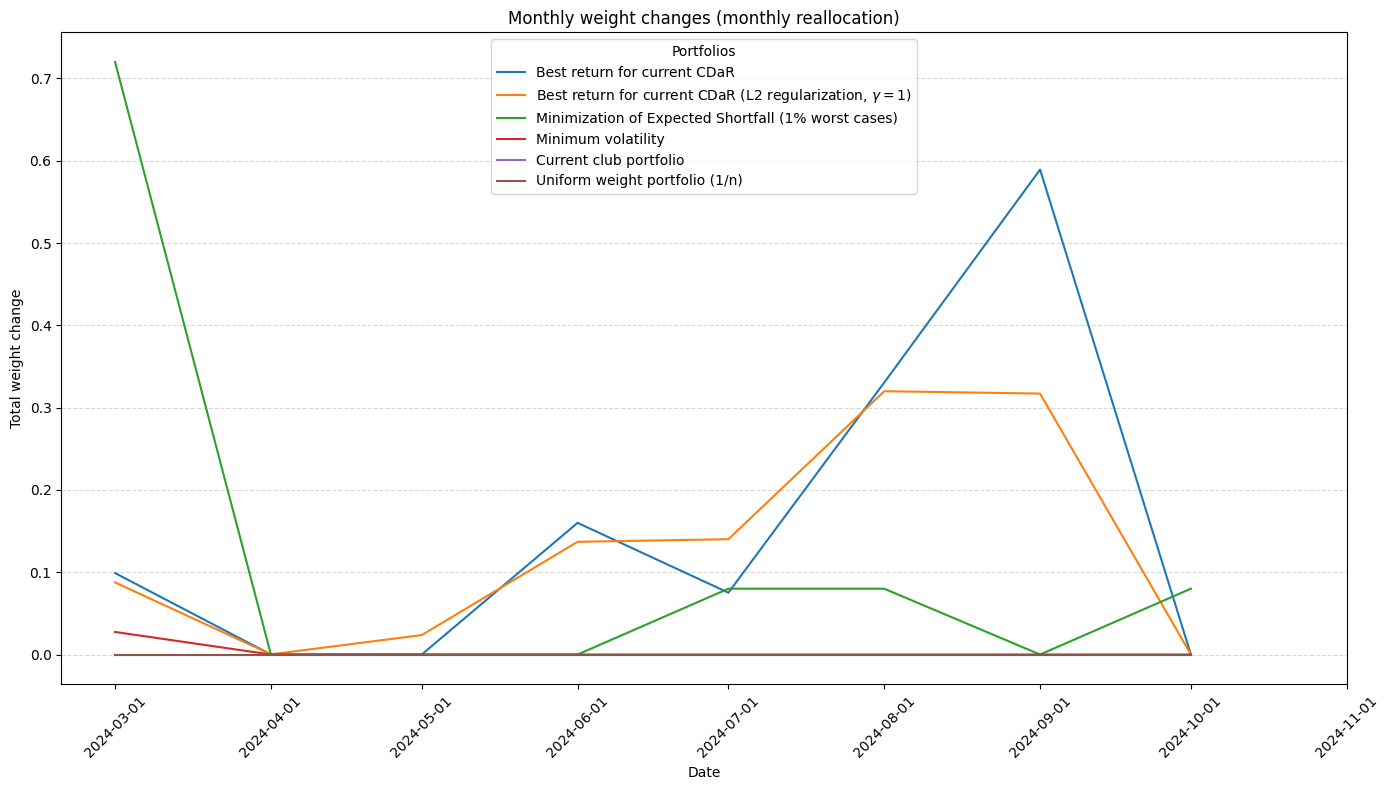

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pypfopt import expected_returns, EfficientFrontier
from pypfopt import CovarianceShrinkage


weights_dict = pd.DataFrame({
    "Best return for current CDaR" : pd.Series(cleaned_weights_eff_cdar),
    r"Best return for current CDaR (L2 regularization, $\gamma = 1$)" : pd.Series(cleaned_weights_eff_cdar_L2),
    "Minimization of Expected Shortfall (1% worst cases)" : pd.Series(cleaned_weights_min_cvar), 
    'Minimum volatility': pd.Series(cleaned_weights_min_vol),
    'Current club portfolio': pd.Series(club_weights),
    "Uniform weight portfolio (1/n)" : pd.Series(unif_weights)
})

# Cost 
c = 0.01
portfolio_cum_returns = {}
monthly_weight_changes = {}

# Ensure df_test dates are datetime objects
df_test.index = pd.to_datetime(df_test.index)
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize(None)  # Remove timezone information
df_test.index = df_test.index.tz_localize(None)  # Remove timezone information


# Start dates for each month
monthly_dates = pd.date_range(start=start_test_date, end=end_test_date, freq='MS')
monthly_dates = [d.strftime('%Y-%m-%d') for d in monthly_dates]

# Monthly reoptimization for each method
for method_name, current_weights in weights_dict.items():
    cum_returns = [1]  # Cumulative returns (starting with 1)
    weight_changes = []  # No changes initially
    for i, start_date in enumerate(monthly_dates[:-1]):
        end_date = monthly_dates[i + 1]  # End of the current month

        # Extract the current month's data using .loc[] to ensure date compatibility
        month_data = expected_returns.returns_from_prices(df_test.loc[start_date:end_date])  # Use loc to extract current month
        
        # Reoptimization with the corresponding method
        nine_month_ago = pd.to_datetime(start_date) - pd.DateOffset(months=9)  # Start of the previous year
        data_until_now = pd.concat([df[nine_month_ago:start_date], df_test[nine_month_ago:start_date]])
        historical_returns = expected_returns.returns_from_prices(data_until_now)
        mu = expected_returns.ema_historical_return(data_until_now)  # Expected returns (historical)
        S = CovarianceShrinkage(data_until_now).ledoit_wolf(shrinkage_target = "constant_correlation")   # Covariance matrix
        ef = EfficientFrontier(mu, S)
        ef.add_objective(objective_functions.transaction_cost, w_prev=current_weights, k=c)
        ef.add_constraint(lambda x : x >= minimal_w)
        ef.add_constraint(lambda x : x <= maximal_w)
        
        # Choose optimization based on the method name
        if "current CDaR" in method_name:
            actual_return = np.dot(current_weights, mu)
            if "regularization" in method_name:
                new_weights,_,ActualCDaR = get_weights_CDaR(option="L2 regularization", c = c, curr=current_weights, gamma = 1)
            else:
                new_weights,_,ActualCDaR = get_weights_CDaR(option="normal", c = c, curr = current_weights)
        elif "Minimum volatility" in method_name:
            ef.min_volatility()
            new_weights = ef.clean_weights()
        elif "Expected" in method_name:
            ef = EfficientCVaR(mu, S,weight_bounds=(0, 1), beta = 0.99, solver = MOSEK)
            ef.add_constraint(lambda x : x >= minimal_w)
            ef.add_constraint(lambda x : x <= maximal_w)
            raw_weights_min_cvar = ef.min_cvar()
            new_weights = ef.clean_weights() 
        if "club" in method_name or "Uniform" in method_name:
            new_weights = list(current_weights)
        else:
            new_weights = list(new_weights.values())
        month_returns = month_data @ new_weights  # Weighted returns
        weight_diff = np.abs(new_weights - current_weights)  # Weight difference
        
        # Calculate transaction costs
        transaction_cost = c * weight_diff.sum()  # Total transaction cost

        # Calculate cumulative returns adjusted for costs
        cum_returns.append(cum_returns[-1] * (1 + month_returns.sum()-transaction_cost))  # Add adjusted monthly return

        # Store weight changes
        weight_changes.append(weight_diff.sum())
        # Update current weights
        current_weights = np.array(list(new_weights))
    
    # Store results for this portfolio
    portfolio_cum_returns[method_name] = cum_returns
    monthly_weight_changes[method_name] = weight_changes


# Convert to DataFrame for plotting
portfolio_cum_returns_df = pd.DataFrame(portfolio_cum_returns, index=monthly_dates)
monthly_weight_changes_df = pd.DataFrame(monthly_weight_changes, index=monthly_dates[:-1])

# Convert monthly_dates to datetime objects
monthly_dates_dt = pd.to_datetime(monthly_dates)

# Plot cumulative returns
plt.figure(figsize=(14, 8))
for portfolio, returns in portfolio_cum_returns_df.items():
    plt.plot(monthly_dates_dt, returns, label=portfolio)

plt.title("Cumulative returns adjusted for costs (monthly reallocation)")
plt.xlabel("Date")
plt.ylabel("Adjusted cumulative return")
plt.legend(title="Portfolios")
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Set x-axis ticks
plt.xticks(monthly_dates_dt, rotation=45)  # Ensure datetime objects for xticks
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Ensure monthly intervals
plt.tight_layout()
plt.show()

# Plot monthly weight changes
plt.figure(figsize=(14, 8))
for portfolio, changes in monthly_weight_changes_df.items():
    plt.plot(monthly_dates_dt[:-1], changes, label=portfolio)

plt.title("Monthly weight changes (monthly reallocation)")
plt.xlabel("Date")
plt.ylabel("Total weight change")
plt.legend(title="Portfolios")
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Set x-axis ticks
plt.xticks(monthly_dates_dt, rotation=45)  # Ensure datetime objects for xticks
plt.tight_layout()
plt.show()


## No more comparison with the club's portfolio, just use the CLUB's assets (and use the previous year's data), cost 1%, transition from empty portfolio -> new portfolio, change of assets at the beginning of the month, return at the end of the month

In [28]:
start_train_date = "2019-01-01"
end_train_date = "2024-01-01"
start_test_date = end_train_date
end_test_date = "2024-11-25"

In [29]:
df = yf.download(list(tickers.keys()), start=start_train_date, end=end_train_date)['Close'].dropna()
df.index = df.index.strftime('%Y-%m-%d') # Omit hour
df_test =  yf.download(list(tickers.keys()), start=start_test_date, end=end_test_date)['Close'].dropna()
df_test.index = df_test.index.strftime('%Y-%m-%d') 


[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed


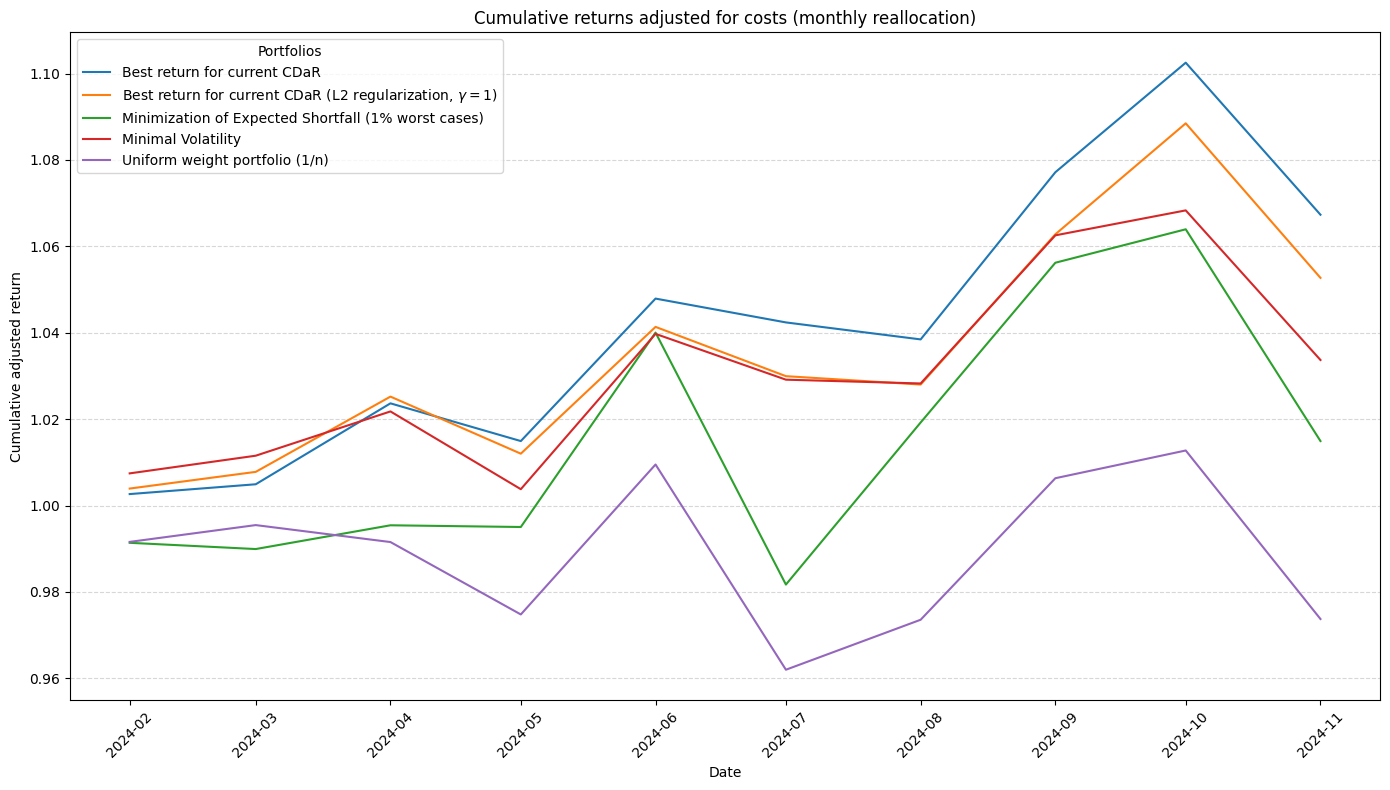

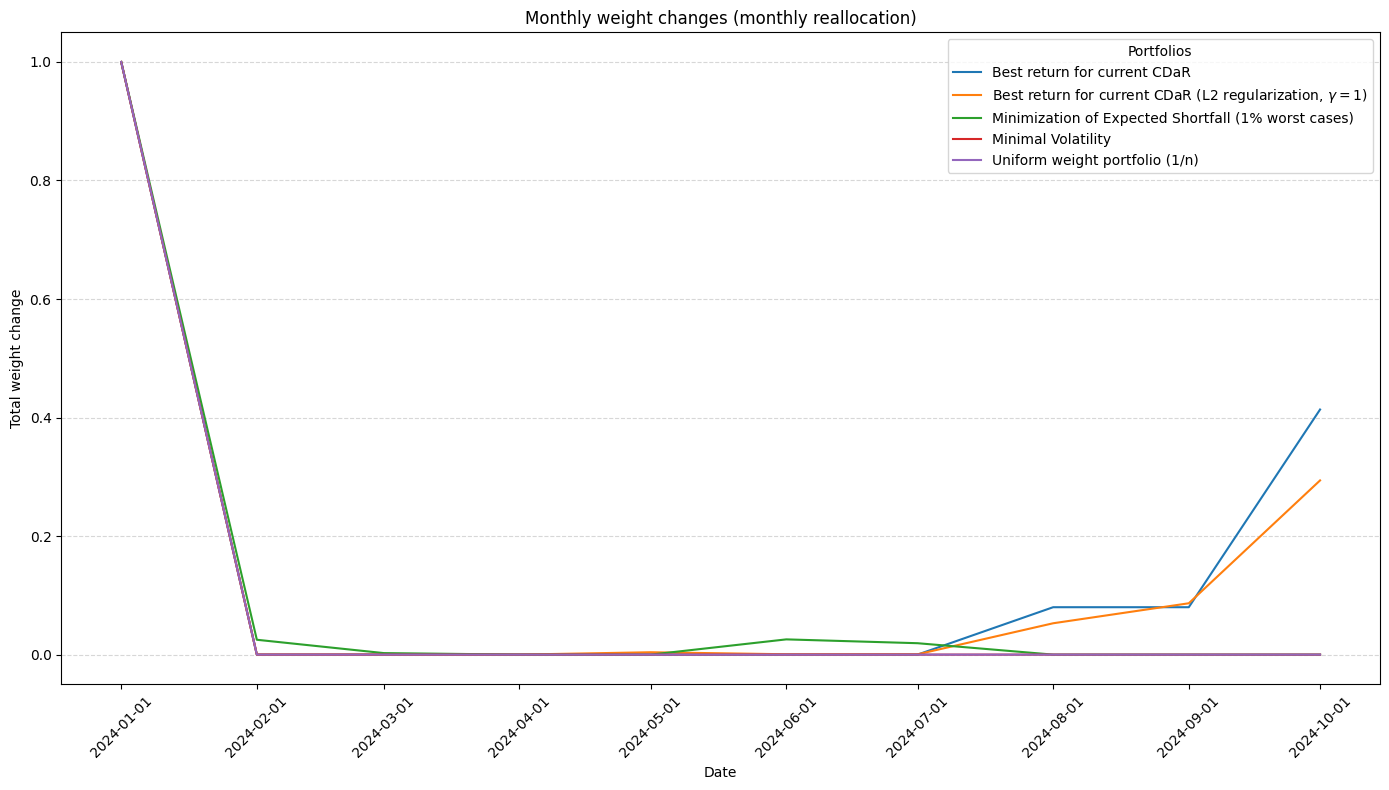

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pypfopt import expected_returns, EfficientFrontier
from pypfopt import CovarianceShrinkage


zero_weights = pd.Series([0]*len(cleaned_weights_eff_cdar))
weights_dict = pd.DataFrame({
    "Best return for current CDaR" : zero_weights,
    r"Best return for current CDaR (L2 regularization, $\gamma = 1$)" : zero_weights,
    "Minimization of Expected Shortfall (1% worst cases)" : zero_weights, 
    'Minimal Volatility': zero_weights,
    "Uniform weight portfolio (1/n)" : zero_weights
})


# Cost 
c = 0.01
portfolio_cum_returns = {}
monthly_weight_changes = {}

# Ensure the dates in df_test are datetime objects
df_test.index = pd.to_datetime(df_test.index)

# Start dates of each month
monthly_dates = pd.date_range(start=start_test_date, end=end_test_date, freq='MS')
monthly_dates = [d.strftime('%Y-%m-%d') for d in monthly_dates]


# Monthly re-optimization for each method
for method_name, current_weights in weights_dict.items():
    cum_returns = []  # Cumulative returns (starts with 1)
    weight_changes = []  # No initial change
    
    for i, start_date in enumerate(monthly_dates[:-1]):
        end_date = monthly_dates[i + 1]  # End of the current month

        # Extract the current month's data using .loc[] to ensure date compatibility
        month_data = expected_returns.returns_from_prices(df_test.loc[start_date:end_date])  # Use loc to extract the current month
        
        # Reoptimization with the corresponding method
        one_year_ago = str(pd.to_datetime(start_date) - pd.DateOffset(years=1))  # Start of the previous year
        data_until_now = pd.concat([df[one_year_ago:start_date], df_test[one_year_ago:start_date]])
        historical_returns = expected_returns.returns_from_prices(data_until_now)
        mu = expected_returns.ema_historical_return(data_until_now)  # Expected returns (historical)
        S = CovarianceShrinkage(data_until_now).ledoit_wolf(shrinkage_target = "constant_correlation")   # Covariance matrix
        ef = EfficientFrontier(mu, S)
        ef.add_objective(objective_functions.transaction_cost, w_prev=current_weights, k=c)
        ef.add_constraint(lambda x : x >= minimal_w)
        ef.add_constraint(lambda x : x <= maximal_w)
        
        # Choose optimization based on the method name
        if "current CDaR" in method_name:
            actual_return = np.dot(current_weights, mu)
            if "regularization" in method_name:
                new_weights,_,_ = get_weights_CDaR(option="L2 regularization", c = c, curr=current_weights, gamma = 1)
            else:
                new_weights,_,_ = get_weights_CDaR(option="normal", c = c, curr = current_weights)
        elif "Minimal Volatility" in method_name:
            ef.min_volatility()
            new_weights = ef.clean_weights()
        elif "Expected" in method_name:
            ef = EfficientCVaR(mu, S, weight_bounds=(0, 1), beta = 0.99, solver = MOSEK)
            ef.add_objective(objective_functions.transaction_cost, w_prev=current_weights, k=c)
            ef.add_constraint(lambda x : x >= minimal_w)
            ef.add_constraint(lambda x : x <= maximal_w)
            raw_weights_min_cvar = ef.min_cvar()
            new_weights = ef.clean_weights()
        if "Unif" in method_name:
            new_weights = [0.05 for k in range(len(current_weights))]

        else:
            new_weights = list(new_weights.values())
        month_returns = month_data @ new_weights  # Weighted returns
        weight_diff = np.abs(new_weights - current_weights)  # Weight difference
        
        # Calculate transaction costs
        transaction_cost = c * weight_diff.sum()  # Total transaction cost

        # Calculate cumulative returns adjusted for costs
        if(len(cum_returns) == 0):
            cum_returns.append((1 + month_returns.sum()-transaction_cost))  # Add the adjusted monthly return
        else:
            cum_returns.append(cum_returns[-1] * (1 + month_returns.sum()-transaction_cost))  # Add the adjusted monthly return

        # Store the weight changes
        weight_changes.append(weight_diff.sum())
        # Update the current weights
        current_weights = np.array(list(new_weights))
    
    # Store the results for this portfolio
    portfolio_cum_returns[method_name] = cum_returns
    monthly_weight_changes[method_name] = weight_changes


# Convert to DataFrame for plotting
portfolio_cum_returns_df = pd.DataFrame(portfolio_cum_returns, index=monthly_dates[1:])
monthly_weight_changes_df = pd.DataFrame(monthly_weight_changes, index=monthly_dates[:-1])

# Convert monthly_dates to datetime objects
monthly_dates_dt = pd.to_datetime(monthly_dates)

# Plot cumulative returns
plt.figure(figsize=(14, 8))
for portfolio, returns in portfolio_cum_returns_df.items():
    plt.plot(monthly_dates_dt[1:], returns, label=portfolio)

plt.title("Cumulative returns adjusted for costs (monthly reallocation)")
plt.xlabel("Date")
plt.ylabel("Cumulative adjusted return")
plt.legend(title="Portfolios")
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Set x-axis ticks
plt.xticks(monthly_dates_dt[1:], rotation=45)  # Ensure datetime objects for xticks
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Ensure monthly intervals
plt.tight_layout()
plt.show()

# Plot monthly weight changes
plt.figure(figsize=(14, 8))
for portfolio, changes in monthly_weight_changes_df.items():
    plt.plot(monthly_dates_dt[:-1], changes, label=portfolio)

plt.title("Monthly weight changes (monthly reallocation)")
plt.xlabel("Date")
plt.ylabel("Total weight change")
plt.legend(title="Portfolios")
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Set x-axis ticks
plt.xticks(monthly_dates_dt[:-1], rotation=45)  # Ensure datetime objects for xticks
plt.tight_layout()
plt.show()


## Model limitations

- Too dependent on dates and no mathematical justification for the choice of dates, useful to include COVID to see how the portfolios reacted to the downside.
- Likely too few stocks for optimization, which restricts possibilities.
- The ability to balance the stocks doesn't seem to improve returns; there's a buying phenomenon when a stock increases in value, neglecting older stocks that could have risen, thus the costs reduce the returns, and the changes (even with a cost of 0) limit long-term gains on stock selection.
- The club's portfolio was not built with the weight constraints between 0.02 and 0.1.


[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  5 of 5 completed


Ticker
2B78.DE       7.542000
AAPL        224.680307
AED.BR       58.049999
BFIT.AS      21.260000
BX          180.904895
ENPH         67.547042
EVO.ST       82.496509
IESE.AS      69.180000
IGLN.L       62.181964
IQQH.DE       6.705000
MC.PA       592.500000
MRK          96.222585
MSFT        400.889564
NESN.SW      82.055400
OGN          15.024129
RCF.F        88.459999
STMPA.PA     24.270000
TCEHY         6.274714
UMI.BR       10.200000
WLN.PA        6.652000
Name: 2024-11-29 00:00:00+00:00, dtype: float64
18599.954146627602


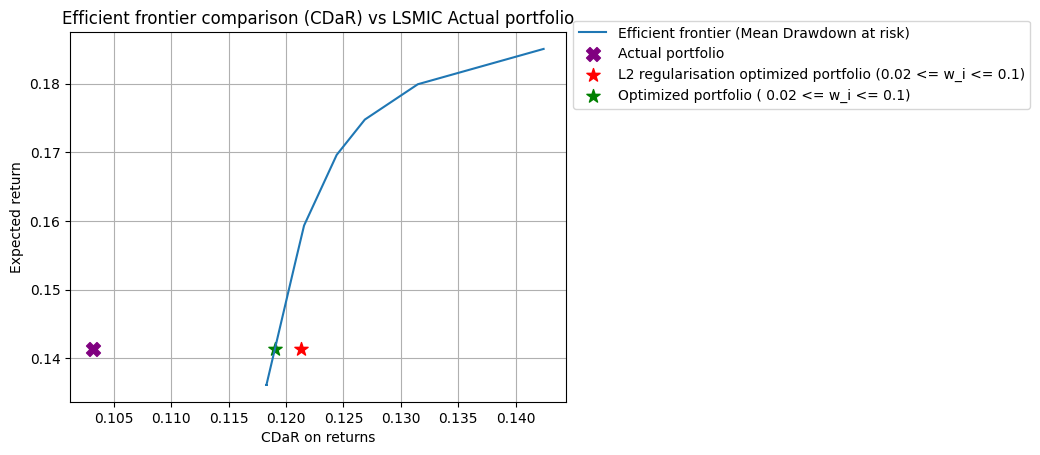

In [32]:
start_train_date = "2023-06-01"
end_train_date = "2024-12-01"
df = yf.download(list(tickers.keys()), start=start_train_date, end=end_train_date)['Close'].dropna()
df.index = df.index.strftime('%Y-%m-%d') # Omettre l'heure sur la date

tickers_curr = {
    "2B78.DE": "EUR", "AAPL": "USD", "AED.BR": "EUR", "BFIT.AS": "EUR",
    "BX": "USD", "EVO.ST": "SEK", "ENPH": "USD", "IGLN.L": "GBP",
    "IESE.AS": "EUR", "IQQH.DE": "EUR", "MC.PA": "EUR", "MRK": "USD",
    "MSFT": "USD", "NESN.SW": "CHF", "OGN": "USD", "RCF.F": "EUR",
    "STMPA.PA": "EUR", "TCEHY": "HKD", "UMI.BR": "EUR", "WLN.PA": "EUR"
}


df = yf.download(list(tickers_curr.keys()), start=start_train_date, end=end_train_date)['Close'].dropna()

currencies = set(tickers_curr.values())
fx_tickers = [f"{curr}EUR=X" for curr in currencies if curr != "EUR"] 
fx_rates = yf.download(fx_tickers, start=start_train_date, end=end_train_date)['Close']

fx_rates['EUR'] = 1.0  
fx_rates = fx_rates.ffill().bfill() 

fx_rates.columns = [col.replace('=X', '').replace('EUR', '') for col in fx_rates.columns]

for ticker, currency in tickers_curr.items():
    if currency != "EUR":
        conversion_rate = fx_rates[currency]
        df[ticker] = df[ticker] * conversion_rate

last_prices = df.iloc[-1]
print(last_prices)
value_by_ticker = [tickers[ticker_name]*last_prices.loc[ticker_name] for ticker_name in last_prices.index.tolist()]
portfolio_value = np.sum(value_by_ticker)
actual_weights = [val/portfolio_value for val in value_by_ticker]
print(portfolio_value)


confidence_level = 0.99

mu = expected_returns.ema_historical_return(df)
actual_return = np.dot(actual_weights, mu)
historical_returns = expected_returns.returns_from_prices(df)

target_returns = np.linspace(0, max(mu), 200)
CDaR_Drawdown = []
returns_Drawdown = []

for target_return in target_returns:
    try:
        es = EfficientCDaR(mu, historical_returns, weight_bounds=(0, 1), beta=confidence_level, solver=MOSEK)
        es.add_constraint(lambda x: x >= minimal_w)
        es.add_constraint(lambda x: x <= maximal_w)
        es.efficient_return(target_return)
        portfolio_return, portfolio_CDaR = es.portfolio_performance()
        CDaR_Drawdown.append(portfolio_CDaR)
        returns_Drawdown.append(portfolio_return)
    except:
        break

plt.plot(CDaR_Drawdown, returns_Drawdown, label = "Efficient frontier (Mean Drawdown at risk)")

portfolio_returns = historical_returns.dot(actual_weights)
cumulative_returns = (1 + portfolio_returns).cumprod()
peak = cumulative_returns.cummax()
drawdowns = (cumulative_returns - peak) / peak
VaR_drawdown_actual = np.quantile(-drawdowns, confidence_level)
ActualCDaR = -drawdowns[drawdowns <= -VaR_drawdown_actual].mean()

plt.scatter(ActualCDaR, actual_return, marker="X", color="purple", s=100, label="Actual portfolio")
 
# Best Return for the Same CDaR
def get_weights_CDaR(option = "normal", min_weights = minimal_w, max_weights = maximal_w, gamma = 1, c = None, curr = None):
    es = EfficientCDaR(mu, historical_returns, weight_bounds=(0, 1), beta = confidence_level, solver = MOSEK)
    es.add_constraint(lambda x : x >= min_weights)
    es.add_constraint(lambda x : x <= max_weights)
    if(c != None):
        es.add_objective(objective_functions.transaction_cost, w_prev= curr, k=c)
    if option == "normal":
        weights_eff_cdar = es.efficient_return(actual_return)
        cleaned_weights_eff_cdar = es.clean_weights()
        optimized_return, optimized_CDaR= es.portfolio_performance()
        return cleaned_weights_eff_cdar, optimized_return, optimized_CDaR
    elif option == "L2 regularisation":
        es.add_objective(objective_functions.L2_reg, gamma= gamma)
        weights_eff_cdar_L2 = es.efficient_return(actual_return)
        cleaned_weights_eff_cdar_L2 = es.clean_weights()
        optimized_return_L2, optimized_CDaR_L2 = es.portfolio_performance()
        return cleaned_weights_eff_cdar_L2,optimized_return_L2, optimized_CDaR_L2
    else:
        return
    
# Portfolio with a penalty on zero weights (L2 regularization)
cleaned_weights_eff_cdar_L2, optimized_return_L2, optimized_CDaR_L2 = get_weights_CDaR("L2 regularisation")
plt.scatter(optimized_CDaR_L2, optimized_return_L2, marker="*", color="red", s=100, label="L2 regularisation optimized portfolio (0.02 <= w_i <= 0.1)")
cleaned_weights_eff_cdar, optimized_return, optimized_CDaR = get_weights_CDaR("normal")
plt.scatter(optimized_CDaR, optimized_return, marker="*", color="green", s=100, label="Optimized portfolio ( 0.02 <= w_i <= 0.1)")


plt.title("Efficient frontier comparison (CDaR) vs LSMIC Actual portfolio")
plt.xlabel("CDaR on returns")
plt.ylabel("Expected return")
plt.legend(bbox_to_anchor = (1,1.05))
plt.grid()
plt.show()

club_weights = {list(tickers.keys())[i]:actual_weights[i] for i in range(len(actual_weights))}

In [33]:
ticker_names = {
    "2B78.DE": "iShares Healthcare Innovation UCITS ETF",
    "AAPL": "Apple Inc.",
    "AED.BR": "Aedifica NV/SA",
    "BFIT.AS": "Basic-Fit N.V.",
    "BX": "Blackstone Inc.",
    "EVO.ST": "Evolution AB (publ)",
    "ENPH": "Enphase Energy, Inc.",
    "IGLN.L": "iShares Physical Gold ETC",
    "IESE.AS": "iShares MSCI Europe SRI UCITS ETF EUR (Acc)",
    "IQQH.DE": "iShares Global Clean Energy UCITS ETF USD (Dist)",
    "MC.PA": "LVMH Moët Hennessy - Louis Vuitton, Société Européenne",
    "MRK": "Merck & Co., Inc.",
    "MSFT": "Microsoft Corporation",
    "NESN.SW": "Nestlé S.A.",
    "OGN": "Organon & Co.",
    "RCF.F": "Teleperformance SE",
    "STMPA.PA": "STMicroelectronics N.V.",
    "TCEHY": "Tencent Holdings Limited",
    "UMI.BR": "Umicore SA",
    "WLN.PA": "Worldline SA"
}

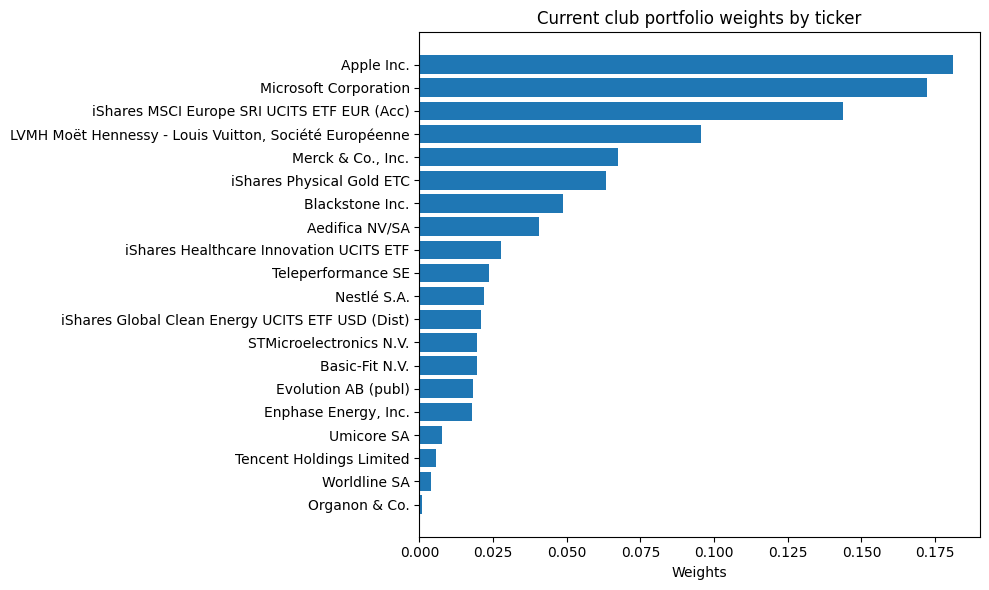

In [34]:
desc = sorted(club_weights.items(), key=lambda x: x[1], reverse=True)
labels = [ticker_names[i[0]] for i in desc]  # Sorted tickers
vals = [i[1] for i in desc]    # Corresponding weights

fig, ax = plt.subplots(figsize=(10, 6))
y_pos = np.arange(len(labels))  # Tickers positions

ax.barh(y_pos, vals)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels) 
ax.invert_yaxis()
ax.set_xlabel('Weights')
ax.set_title('Current club portfolio weights by ticker')

plt.tight_layout()
plt.show()


In [35]:
cleaned_weights_eff_cdar_L2

OrderedDict([('2B78.DE', 0.04582),
             ('AAPL', 0.09428),
             ('AED.BR', 0.02397),
             ('BFIT.AS', 0.02),
             ('BX', 0.1),
             ('ENPH', 0.02),
             ('EVO.ST', 0.02),
             ('IESE.AS', 0.09354),
             ('IGLN.L', 0.1),
             ('IQQH.DE', 0.02),
             ('MC.PA', 0.02),
             ('MRK', 0.1),
             ('MSFT', 0.1),
             ('NESN.SW', 0.08114),
             ('OGN', 0.02),
             ('RCF.F', 0.02),
             ('STMPA.PA', 0.02),
             ('TCEHY', 0.06125),
             ('UMI.BR', 0.02),
             ('WLN.PA', 0.02)])

In [36]:
portfolio_value*0.02

371.999082932552

In [37]:
latest_prices = df.iloc[-1]  # prix récents à la fin de la période
da = DiscreteAllocation(cleaned_weights_eff_cdar_L2, latest_prices, total_portfolio_value=portfolio_value)
allocation_L2, leftover = da.lp_portfolio()

c:\Users\porti\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [38]:
allocation_L2

{'2B78.DE': 112,
 'AAPL': 8,
 'AED.BR': 8,
 'BFIT.AS': 17,
 'BX': 10,
 'ENPH': 6,
 'EVO.ST': 5,
 'IESE.AS': 25,
 'IGLN.L': 30,
 'IQQH.DE': 58,
 'MRK': 20,
 'MSFT': 5,
 'NESN.SW': 19,
 'OGN': 24,
 'RCF.F': 4,
 'STMPA.PA': 16,
 'TCEHY': 184,
 'UMI.BR': 38,
 'WLN.PA': 55}

In [39]:
leftover

22.62637362150417

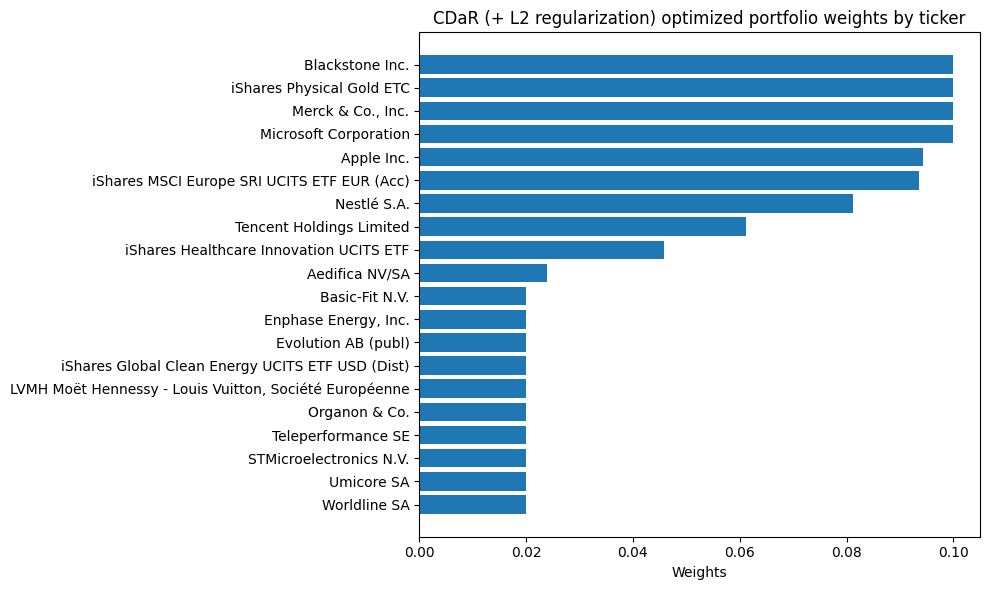

In [40]:
desc = sorted(cleaned_weights_eff_cdar_L2.items(), key=lambda x: x[1], reverse=True)
labels = [ticker_names[i[0]] for i in desc] # Tickers triés
vals = [i[1] for i in desc]    # Poids correspondants

fig, ax = plt.subplots(figsize=(10, 6))
y_pos = np.arange(len(labels))  # Positions des tickers

ax.barh(y_pos, vals)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels) 
ax.invert_yaxis()
ax.set_xlabel('Weights')
ax.set_title('CDaR (+ L2 regularization) optimized portfolio weights by ticker')

plt.tight_layout()
plt.show()


In [41]:
for action in cleaned_weights_eff_cdar_L2.keys():
    if action not in allocation_L2:
        allocation_L2[action] = 0

In [42]:
data = []
for ticker, weight in cleaned_weights_eff_cdar_L2.items():
    percentage = weight * 100  # Calcul du pourcentage
    data.append([ticker_names[ticker], ticker,tickers[ticker],allocation_L2[ticker], -tickers[ticker] + allocation_L2[ticker], percentage ])

columns = ["Asset name", "Ticker", "Current number of shares", "Number of shares post optimization", "Difference in number of shares", "Percentage (%) of optimized portfolio"]
df = pd.DataFrame(data, columns=columns)

# Sorting the dataframe by descending percentage
df_sorted = df.sort_values(by='Percentage (%) of optimized portfolio', ascending=False)
df_sorted

,Asset name,Ticker,Current number of shares,Number of shares post optimization,Difference in number of shares,Percentage (%) of optimized portfolio
4,Blackstone Inc.,BX,5,10,5,10.000
8,iShares Physical Gold ETC,IGLN.L,43,30,-13,10.000
11,"Merck & Co., Inc.",MRK,13,20,7,10.000
12,Microsoft Corporation,MSFT,8,5,-3,10.000
1,Apple Inc.,AAPL,15,8,-7,9.428
7,iShares MSCI Europe SRI UCITS ETF EUR (Acc),IESE.AS,17,25,8,9.354
13,Nestlé S.A.,NESN.SW,5,19,14,8.114
17,Tencent Holdings Limited,TCEHY,17,184,167,6.125
0,iShares Healthcare Innovation UCITS ETF,2B78.DE,68,112,44,4.582
2,Aedifica NV/SA,AED.BR,13,8,-5,2.397


In [43]:
def plot_template(weights_dict_optimized, weights_dict_current):
    """
    Weights given in absolute terms, not in percentage
    - weights_dict_optimized : dictionary of optimal weights, {stock: weight}.
    - weights_dict_current : dictionary of current weights, {stock: weight}.
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    weights_dict_optimized = {k: v * 100 for k, v in weights_dict_optimized.items()}
    weights_dict_current = {k: v * 100 for k, v in weights_dict_current.items()}
    weights_df = pd.DataFrame({
        'Optimized portfolio (%)': pd.Series(weights_dict_optimized),
        'Current portfolio (%)': pd.Series(weights_dict_current)
    })
    weights_df = weights_df.sort_values(by='Optimized portfolio (%)', ascending=False)
    plt.figure(figsize=(14, 8))
    bar_width = 0.35
    index = np.arange(len(weights_df))
    plt.bar(index, weights_df['Optimized portfolio (%)'], bar_width, label='L2 CDaR optimized portfolio', color='blue')
    plt.bar(index + bar_width, weights_df['Current portfolio (%)'], bar_width, label='Current portfolio', color='green')
    plt.xlabel('Asset', fontsize=14)
    plt.ylabel('Weight (%)', fontsize=14)
    plt.title('', fontsize=16)
    plt.xticks(index + bar_width / 2, weights_df.index, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()
    return weights_df

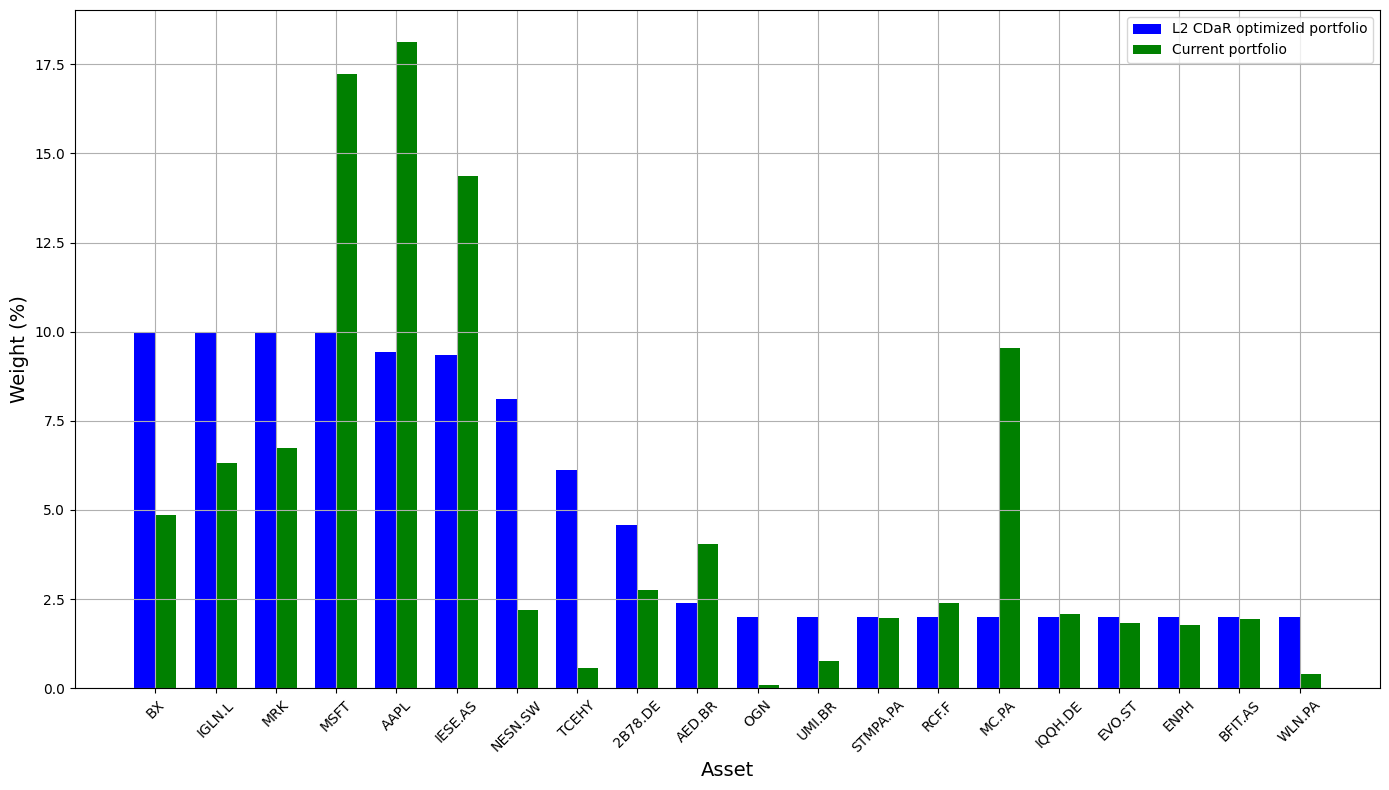

,Optimized portfolio (%),Current portfolio (%)
BX,10.000,4.863047
IGLN.L,10.000,6.322919
MRK,10.000,6.725251
MSFT,10.000,17.242604
AAPL,9.428,18.119424
IESE.AS,9.354,14.375436
NESN.SW,8.114,2.205796
TCEHY,6.125,0.573497
2B78.DE,4.582,2.757297
AED.BR,2.397,4.057268


In [44]:
plot_template(cleaned_weights_eff_cdar_L2,club_weights)